In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

sub_size = 20
X_size = 600

X_star = np.linspace(0, 1, X_size)
X = X_star.reshape(-1,1)
# Evenly sample X_size points from sub_size points
sorted_indices = np.linspace(0, X_size-1, sub_size, dtype=int)  # Generate sub_size evenly spaced indices.

X_sub = X[sorted_indices]
def RBF_kernel(X, Y, sigma2):
    X = np.array(X)
    Y = np.array(Y)
    mat1 = np.sum(X**2, 1).reshape(-1, 1)
    mat2 = np.sum(Y**2, 1)
    mat = mat1 + mat2 - 2 * np.dot(X, Y.T)
    mat = np.exp(-0.5 / sigma2 * mat)
    return mat

kTup = 8  # Hyperparameter： sigma squared
K = RBF_kernel(X_sub, X_sub, kTup)  # Kernel Matrix of Fixed-Size Support Vectors

eigenvalue, featurevector = np.linalg.eig(K)       #Eigenvalue Decomposition of Kernel Matrix
A = eigenvalue             
B = featurevector

KK = RBF_kernel(X, X_sub, kTup)      # Kernel Matrix Generated from the Total Sample Set and Subsample Sets
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                               # Primal form of the Sample Set Feature Function  

X_F_1 = X_F[0,:]
X_F_1 = X_F_1.reshape(1, sub_size)

X = X_star.reshape(-1,1)
X = X[1:, :]
KK = RBF_kernel(X, X_sub, kTup)     

X_diag = np.diag(X.flatten())   # Sample Set Diagonal Matrix
X_sub_diag = np.diag(X_sub.flatten())   # Subsample Diagonal Matrix
KK_D = ( KK @ X_sub_diag - X_diag @ KK ) / (kTup)  # First-order derivative of the kernel function

eigenvalue, featurevector = np.linalg.eig(K)      
A = eigenvalue             
B = featurevector
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                               # Primal form of the Sample Set Feature Function  

eigenvalue, featurevector = np.linalg.eig(K)     
A = eigenvalue             
B = featurevector
K_1 = KK_D @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F_D = K_1 @ A_lam
X_F_D = F_D                                   # First-Order Derivative of the Sample Set Feature Function

A = X_F_D
B = X_F
C = X_F_1



n = X_size - 1     
m_vars = sub_size 

r = 1000000   #Hyperparameter: gamma

# Differential equation parameters
p = -1
t = X
I = np.ones((n, 1))          
E = np.eye(m_vars)           

# Initial Guess 
w = np.zeros((m_vars, 1))
b = 0.0
m = 0.0
y = np.zeros((n, 1))

max_iter = 25  # Maximum Number of Iterations
tol = 1e-10 

# Construct the matrix equation and solve it.
for iter in range(max_iter):
    Aw = A @ w
    y_sq = y ** 2
    t_sq = 0 * t ** 2
    
    # Y1: w + rA^T(Aw - y² - t²) + r(-B^T)(y - Bw -bI) + mC^T
    Y1 = w + r * A.T @ (Aw - y_sq - t_sq) + r * (-B.T) @ (y - B @ w - b * I) + m * C.T
    
    # Y2: r*(-I^T)(y - Bw -bI) + m
    Y2 = r * (-I.T) @ (y - B @ w - b * I) + m
    
    # Y3: Cw + b - p
    Y3 = C @ w + b - p
    
    # Y4: r*(-2y)⊙(Aw - y² - t²) + r(y - Bw -bI)
    Y4 = r * (-2 * y) * (Aw - y_sq - t_sq) + r * (y - B @ w - b * I)
    
    F = np.vstack([Y1, Y2, Y3, Y4])
    
    if np.linalg.norm(F) < tol:
        print(f"Converged at iteration {iter}")
        break
    
    J11 = E + r * A.T @ A + r * B.T @ B
    J12 = r * B.T @ I
    J13 = C.T
    J14 = -r * A.T @ (2 * np.diag(y.flatten())) - r * B.T
    
    I_sq = I.T @ I
    J21 = r * I.T @ B
    J22 = r * I_sq 
    J23 = np.array([[1.0]])
    J24 = -r * I.T
    
    J31 = C
    J32 = np.array([[1.0]])
    J33 = np.array([[0.0]])
    J34 = np.zeros((1, n))
    
    diag_y = np.diag(y.flatten())
    J41 = -2 * r * diag_y @ A - r * B
    J42 = -r * I
    J43 = np.zeros((n, 1))
    diag_entries = -2 * r * (Aw.flatten() - 3 * y_sq.flatten() - t_sq.flatten()) + r
    J44 = np.diag(diag_entries)
    
    row1 = np.hstack([J11, J12, J13, J14])
    row2 = np.hstack([J21, J22, J23, J24])
    row3 = np.hstack([J31, J32, J33, J34])
    row4 = np.hstack([J41, J42, J43, J44])
    J = np.vstack([row1, row2, row3, row4])
    
    # J * delta = -F
    try:
        delta = np.linalg.solve(J, -F)
    except np.linalg.LinAlgError:
        print("Jacobian is singular. Using least squares.")
        delta = np.linalg.lstsq(J, -F, rcond=None)[0]
    
    delta_w =  np.real(delta[:m_vars].reshape(-1, 1))
    delta_b =  np.real(delta[m_vars])
    delta_m =  np.real(delta[m_vars + 1])
    delta_y =  np.real(delta[m_vars + 2 : m_vars + 2 + n].reshape(-1, 1))
    
    w += delta_w
    b += delta_b.item()
    m += delta_m.item()
    y += delta_y
    
    print(f"Iteration {iter}: Residual norm = {np.linalg.norm(F):.4e}")

#Calculate the prediction results.
X = X_star.reshape(-1,1)
KK = RBF_kernel(X, X_sub, kTup)     
eigenvalue, featurevector = np.linalg.eig(K)      
A = eigenvalue             
B = featurevector
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                               

y_p =  np.real(np.dot(X_F,w) + b)
# print(y_p)

Iteration 0: Residual norm = 1.0000e+00
Iteration 1: Residual norm = 9.3378e+08
Iteration 2: Residual norm = 2.7700e+07
Iteration 3: Residual norm = 2.1653e+07
Iteration 4: Residual norm = 6.8334e+05
Iteration 5: Residual norm = 5.8123e+03
Iteration 6: Residual norm = 5.0885e+01
Iteration 7: Residual norm = 5.0889e+01
Iteration 8: Residual norm = 5.0889e+01
Iteration 9: Residual norm = 5.0889e+01
Iteration 10: Residual norm = 5.0889e+01
Iteration 11: Residual norm = 5.0889e+01
Iteration 12: Residual norm = 5.0889e+01
Iteration 13: Residual norm = 5.0889e+01
Iteration 14: Residual norm = 5.0890e+01
Iteration 15: Residual norm = 5.0889e+01
Iteration 16: Residual norm = 5.0889e+01
Iteration 17: Residual norm = 5.0889e+01
Iteration 18: Residual norm = 5.0889e+01
Iteration 19: Residual norm = 5.0889e+01
Iteration 20: Residual norm = 5.0889e+01
Iteration 21: Residual norm = 5.0889e+01
Iteration 22: Residual norm = 5.0889e+01
Iteration 23: Residual norm = 5.0889e+01
Iteration 24: Residual nor

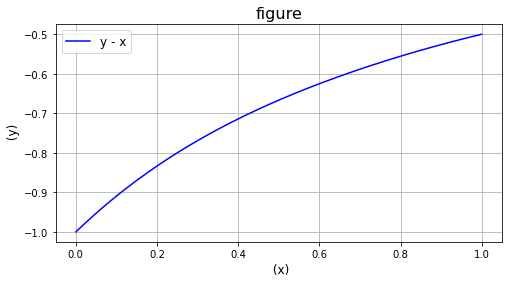

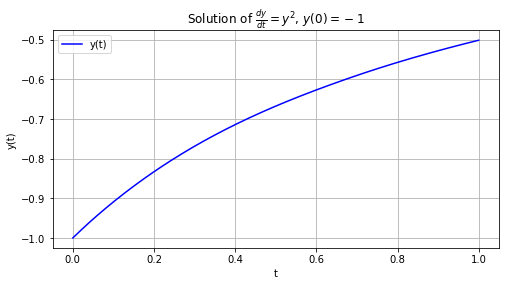

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#graph of the predicted values
x = X 
a = y_p
y = y_p              
plt.figure(figsize=(8, 4)) 
plt.plot(x, y, label="y - x", color="blue", linestyle="-")
plt.title("figure", fontsize=16)
plt.xlabel(" (x)", fontsize=12)
plt.ylabel(" (y)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#graph of the true values
# Define the solution function
def dydt(t, y):
    return y**2 
t_span = (0, 1)
y0 = [-1]
sol = solve_ivp(dydt, t_span, y0, t_eval=np.linspace(0, 1,600))
b = sol.y
plt.figure(figsize=(8, 4))
plt.plot(sol.t, sol.y[0], 'b-', label='y(t)')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Solution of $\\frac{dy}{dt} = y^2$, $y(0)=-1$')
plt.grid(True)
plt.legend()
plt.show()

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

y_p_fsvm = a
y_true = b
R2_fsvm = r2_score(y_p_fsvm, y_true.reshape(-1, 1))
mae_fsvm = mean_absolute_error(y_p_fsvm, y_true.reshape(-1, 1))
rmse_fsvm = mean_squared_error(y_p_fsvm, y_true.reshape(-1, 1), squared = False)
inf_norm_fsvm = np.linalg.norm(y_p_fsvm - y_true.reshape(-1, 1), ord = np.inf)

print(f"R2_fsvm: {R2_fsvm}, mae_fsvm: {mae_fsvm}, rmse_fsvm: {rmse_fsvm}, inf_norm_fsvm: {inf_norm_fsvm}") 


import pandas as pd
data_to_save = pd.DataFrame({
    'y_pred_fsvm': y_p_fsvm.flatten()
})

data_to_save.to_csv('fsvm_05.csv', index=False)
print("fsvm_05.csv")

R2_fsvm: 0.9999419329804644, mae_fsvm: 0.0008785612374557546, rmse_fsvm: 0.0010677030038938212, inf_norm_fsvm: 0.0016691635837189356
数据已保存至 fsvm_05.csv
